# 2: Comparing Reconstruction Methods

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import patato as pat
from patato.data import get_msot_time_series_example
import timeit

# Generate simulated data for the truncated paraboloid in a circular geometry:
from patato.data import generate_basic_simulation

In [2]:
# Simulated data:
p0_simulated, ts_simulated, detectors_simulated = generate_basic_simulation(256)

time_series_simulated = pat.PATimeSeries(ts_simulated[None, None], 
                               dimensions=["frames", "wavelengths", "detectors","timeseries"], 
                               attributes={"fs": 4e7})

Loading model


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:33<00:00,  7.55it/s]


In [7]:
# Replace this with a phantom scan?
phantom_padata = get_msot_time_series_example("so2")[0:1]#, 0:1]

datasets = {"Simulation": (time_series_simulated, detectors_simulated, 1500, None), 
            "Phantom": (phantom_padata.get_time_series(), phantom_padata.get_scan_geometry(), None, phantom_padata)}

In [8]:
# Define the reconstruction methods to compare:
nx = 333 # number of pixels
lx = 2.5e-2 # m

pre_ubp = pat.MSOTPreProcessor(universal_backprojection=True,
                               absolute="real", hilbert=False)
pre_hil = pat.MSOTPreProcessor(lp_filter=7e6, hp_filter=5e3)

das = pat.Backprojection(field_of_view=(lx, lx, 0), 
                             n_pixels=(nx, nx, 1)) # z axis must be specified but is empty in this case.

methods = {"UBP": [pre_ubp, das], "Hilbert Transform": [pre_hil, das]}

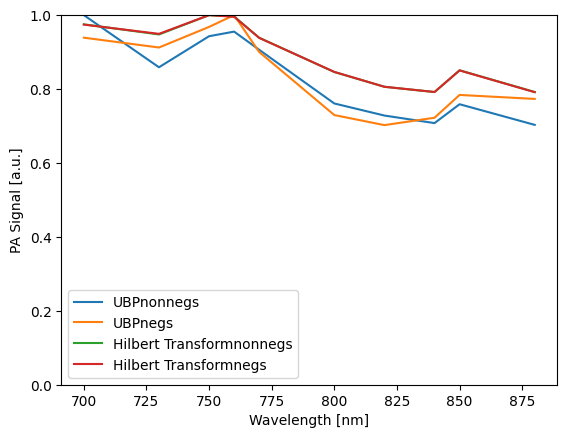

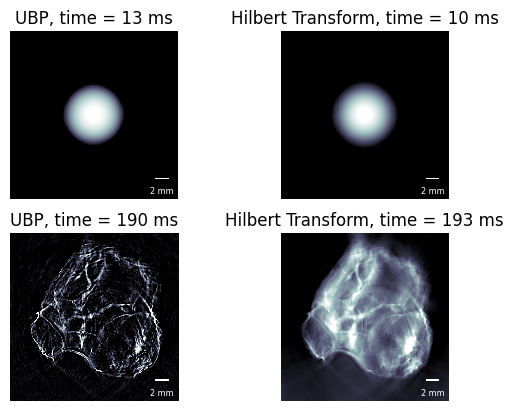

In [15]:
fig2, ax_plot = plt.subplots()
fig, axes = plt.subplots(len(datasets), len(methods))
i = 0
for dataset_name, (time_series, detectors, c, padata) in datasets.items():
    j = 0
    for recon_name, (pre_processor, reconstructor) in methods.items():
        pre_processor.filter = None # Force recomputation of filter
        processed, settings, _ = pre_processor.run(time_series, padata, detectors=detectors)
        rec, _, _ = reconstructor.run(processed, padata, speed_of_sound=c, **settings)
        
        if padata is not None:
            roi = padata.get_rois()["tumour_left", "0"]
            mask, _ = roi.to_mask_slice(rec)
            s = rec.raw_data.copy()
            s[s < 0] = np.nan
            spectrum = np.nanmean(np.squeeze(s.T[mask.T].T), axis=-1)
            spectrum /= np.max(spectrum)
            ax_plot.plot(padata.get_wavelengths(), spectrum, label=recon_name + "nonnegs")
            
            s = rec.raw_data.copy()
            # s[s < 0] = np.nan
            spectrum = np.nanmean(np.squeeze(s.T[mask.T].T), axis=-1)
            spectrum /= np.max(spectrum)
            ax_plot.plot(padata.get_wavelengths(), spectrum, label=recon_name + "negs")
        
        timer = timeit.Timer("processed, settings, _ = pre_processor.run(time_series, padata, detectors=detectors); reconstructor.run(processed, padata, speed_of_sound=c, **settings)", globals=globals())
        time = timer.timeit(number=1)
        rec.imshow(cmap="bone", ax=axes[i, j], clim=(0, np.percentile(rec.raw_data, 99.5)))
        axes[i, j].set_title(recon_name + f", time = {1000 * time/10:.0f} ms")
        j += 1
    i += 1
ax_plot.legend()
ax_plot.set_xlabel("Wavelength [nm]")
ax_plot.set_ylabel("PA Signal [a.u.]")
ax_plot.set_ylim([0, 1])
plt.show()